## API

```julia
heuristic(sensitivity, budget, tradeoff_map)
```

Given the sensitivity values of each state, the overall budget for all states, and a tradeoff
map where the first column represents the accuracy values and the second column costs, return
the selected values for each state.

Example: 
```julia
julia> heuristic(
        [0.45, 0.29, 0.48, 0.68, 0.27],
        11,
        [0.0718114  0.39
         0.059322   0.7
         0.0537408  1.0
         0.0449321  1.8
         0.0373444  4.2])

4-element Vector{Int64}:
4
2
4
4
2
```

Two heuristics are provided in the notebook.

Full signature:
```julia
heuristic(sensitivity::Vector{<:Real}, budget::Real, tradeoff_map::Matrix{<:Real})
```

In [14]:
using JLD2
using FileIO
using Plots

# For heuristic 3
using JuMP
using HiGHS


## Analyzing selection heuristics

┌ Info: true
└ @ Main /Users/jerry/Projects/date24-asd/src/heuristics.ipynb:13


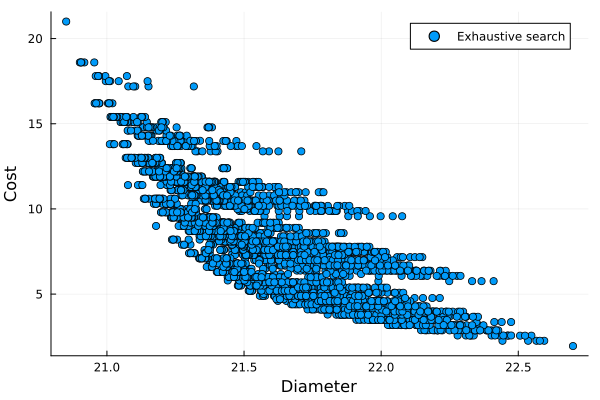

In [2]:
# Read the costs and diameters of experiment data
points = load("../data/exhaustive_points.jld2", "points")[:,2:end]

diameters = zeros(5, 5, 5, 5, 5)
costs = zeros(5, 5, 5, 5, 5)

for i in axes(points, 2)
    coord = points[1, i]
    diameters[coord...] = points[2, i]
    costs[coord...] = points[3, i]
end

@info diameters[:] == points[2,:] && costs[:] == points[3,:]
scatter(diameters[:], costs[:], xlabel="Diameter", ylabel="Cost", label="Exhaustive search")

In [3]:
efficient_net_surfaces = (
    B0 = (acc1 = 77.1, acc5 = 93.3, para = 5.3, flop = 0.39),
    B1 = (acc1 = 79.1, acc5 = 94.4, para = 7.8, flop = 0.70),
    B2 = (acc1 = 80.1, acc5 = 94.9, para = 9.2, flop = 1.0),
    B3 = (acc1 = 81.6, acc5 = 95.7, para = 12, flop = 1.8),
    B4 = (acc1 = 82.9, acc5 = 96.4, para = 19, flop = 4.2),
    B5 = (acc1 = 83.6, acc5 = 96.7, para = 30, flop = 9.9),
    B6 = (acc1 = 84.0, acc5 = 96.8, para = 43, flop = 19),
    B7 = (acc1 = 84.3, acc5 = 97.0, para = 66, flop = 37),
)

efficient_net_map_full = vcat(([100/b.acc1 - 1;; 100/b.acc5 - 1;; b.flop] for b in efficient_net_surfaces)...)
efficient_net_map = efficient_net_map_full[1:5,2:3]

5×2 Matrix{Float64}:
 0.0718114  0.39
 0.059322   0.7
 0.0537408  1.0
 0.0449321  1.8
 0.0373444  4.2

## Heuristics


### Heuristic 1
$$
B_i = B \frac{S_i}{\sum_j S_j}
$$

What if the accuracy-efficiency tradeoff-map is given? We will have to select the discrete points?

Selection process:

1. Select the least expensive option for each state.
2. Starting from the most sensitive state, select the most expensive NN that is no more expensive than the individual budget allows, if the overall budget still has enough headroom (which might be violated by step-1).
3. Starting from the most sensitive state, select the NN that is one level higher than the current level, if the overall budget has enough headroom.

In [4]:
# Split budget according to sensitivity
heuristic1(sensitivity::Vector{<:Real}, budget::Real) = budget / sum(sensitivity) .* sensitivity
heuristic1(sensitivity::Vector{<:Real}, budget::Real, tradeoff_map::Nothing) = heuristic1(sensitivity, budget)
heuristic1(sensitivity::Vector{<:Real}, budget::Real, tradeoff_map::Matrix{<:Real}) = let
    cost(level) = tradeoff_map[level, 2]
    state_budgets = heuristic1(sensitivity, budget)

    # 1. Select the least expensive option for all states.
    levels = ones(Int64, size(sensitivity))
    nlevels = size(tradeoff_map, 1)

    # 2. Select the most expensive option within individual budget
    rankings = sortperm(sensitivity, rev=true)
    for state in rankings
        other_costs = sum(map(cost, levels)) - cost(levels[state])
        while levels[state] < nlevels && cost(levels[state] + 1) <= min(state_budgets[state], budget - other_costs)
            levels[state] += 1
        end
    end

    # 3. Any addtional increases
    for i in 1:nlevels, state in rankings
        other_costs = sum(map(cost, levels)) - cost(levels[state])
        if levels[state] < nlevels && cost(levels[state] + 1) <= budget - other_costs
            levels[state] += 1
        end
    end
    levels
end


heuristic1 (generic function with 3 methods)

### Heuristic 2

Process

1. Select the least expensive option for each state.
2. Starting from the most sensitive state, select the most expensive NN allowed by the remaining budget. Continue until all states have been considered.

In [5]:
heuristic2(sensitivity::Vector{<:Real}, budget::Real, tradeoff_map::Matrix{<:Real}) = let
    cost(level) = tradeoff_map[level, 2]

    # 1. Select the least expensive option for all states
    levels = ones(Int64, size(sensitivity))
    nlevels = size(tradeoff_map, 1)

    # 2. Choose the most expensive network that can be afforded, iterating from most sensitive state
    rankings = sortperm(sensitivity, rev=true) # Return the ordering of states by their index
    for state in rankings
        other_costs = sum(map(cost, levels)) - cost(levels[state])
        while levels[state] < nlevels && cost(levels[state] + 1) <= budget - other_costs
            levels[state] += 1
        end
    end
    levels
end

heuristic2 (generic function with 1 method)

### Heuristic 3

$\min \sum_i s_i e_i$, subject to $\sum c_i < budget$. Tricky: $e_i$ and $c_i$ selected from a list.

In [72]:
heuristic3(sensitivity::Vector{<:Real}, budget::Real, tradeoff_map::Matrix{<:Real}) = let 
    cost(level) = tradeoff_map[level, 2]

    nlevels = size(tradeoff_map, 1)
    nstates = size(sensitivity, 1)

    model = Model(HiGHS.Optimizer)
    @variable(model, a[1:nstates,1:nlevels] >= 0, Int)
    @objective(model, Min, sum(a * tradeoff_map[:,1] .* sensitivity))
    @constraint(model, sum(a * tradeoff_map[:,2]) <= budget)
    for i in 1:nstates
        @constraint(model, sum(a[i,:]) == 1)
    end
    optimize!(model)
    map(argmax, [value.(a)[i,:] for i in axes(value.(a),1)])
end


heuristic3 (generic function with 1 method)

In [73]:
round2g(x) = round(x, sigdigits=2)
heuristic3(round2g.(mul_sensitivity), 11, round2g.(efficient_net_map))

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
6 rows, 25 cols, 50 nonzeros
6 rows, 25 cols, 45 nonzeros

Solving MIP model with:
   6 rows
   25 cols (25 binary, 0 integer, 0 implied int., 0 continuous)
   45 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
 R       0       0         0   0.00%   0.0931166667    0.09765            4.64%        0      0      0         9     0.0s

16.0% inactive integer columns, restarting
Model after restart has 6 rows, 21 cols (21 bin., 0 int., 0 impl., 0 cont.), and 37 nonzeros

         0       0         0   0.00%   0.0931166667    0.09765            4.64%        0      0      0         9 

5-element Vector{Int64}:
 4
 4
 4
 5
 3

### Evaluate heuristics

In [85]:
budget = 14

# Sensitivity values
mul_sensitivity = [0.45, 0.29, 0.48, 0.68, 0.27]
add_sensitivity = [0.35, 0.0, 0.23, 0.52, 0.32]
det_sensitivity = [1.6, 1.8, 2.9, 2.3, 4.3]

sensitivities = [
    ("add", add_sensitivity),
    ("mul", mul_sensitivity), 
    ("det", det_sensitivity)]
heuristics = [
    ("h1", heuristic1),
    # ("h2", heuristic2),
    ("h3", heuristic3)]

# Construct combinations of sensitivities and heuristics
combos = Iterators.product(sensitivities, heuristics)

Base.Iterators.ProductIterator{Tuple{Vector{Tuple{String, Vector{Float64}}}, Vector{Tuple{String, Function}}}}(([("add", [0.35, 0.0, 0.23, 0.52, 0.32]), ("mul", [0.45, 0.29, 0.48, 0.68, 0.27]), ("det", [1.6, 1.8, 2.9, 2.3, 4.3])], Tuple{String, Function}[("h1", heuristic1), ("h3", heuristic3)]))

┌ Info: best
│   collect(best_coord) = [4, 5, 4, 5, 4]
└ @ Main /Users/jerry/Projects/date24-asd/src/heuristics.ipynb:24
┌ Info: h1add
│   selection = [5, 4, 4, 5, 4]
└ @ Main /Users/jerry/Projects/date24-asd/src/heuristics.ipynb:31


Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
6 rows, 25 cols, 50 nonzeros
5 rows, 20 cols, 36 nonzeros

Solving MIP model with:
   5 rows
   20 cols (20 binary, 0 integer, 0 implied int., 0 continuous)
   36 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
 R       0       0         0   0.00%   0.055573448     0.0658036404      15.55%        0      0      0         5     0.0s
 C       0       0         0   0.00%   0.0568002134    0.0609564471       6.82%       51      5      0        10     0.0s

Solving report
  Status            Optimal
  Primal bound      0.0568002133716
  Dual bound        0.0568002133716
  Gap        

┌ Info: h1mul
│   selection = [4, 4, 5, 5, 4]
└ @ Main /Users/jerry/Projects/date24-asd/src/heuristics.ipynb:31
┌ Info: h1det
│   selection = [4, 4, 5, 4, 5]
└ @ Main /Users/jerry/Projects/date24-asd/src/heuristics.ipynb:31
┌ Info: h3add
│   selection = [5, 1, 3, 5, 5]
└ @ Main /Users/jerry/Projects/date24-asd/src/heuristics.ipynb:31
┌ Info: h3mul
│   selection = [4, 4, 5, 5, 4]
└ @ Main /Users/jerry/Projects/date24-asd/src/heuristics.ipynb:31
┌ Info: h3det
│   selection = [4, 4, 5, 4, 5]
└ @ Main /Users/jerry/Projects/date24-asd/src/heuristics.ipynb:31


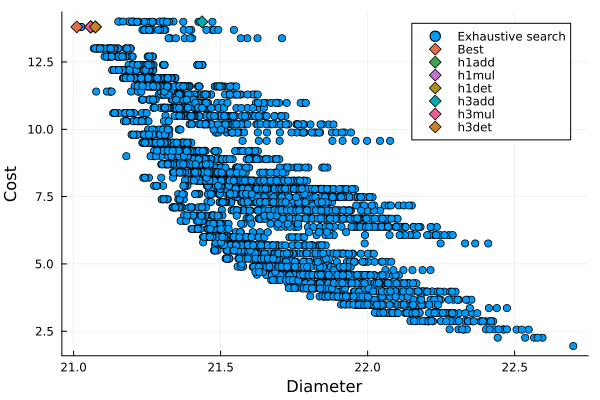

In [86]:
function mark_point!(plt::Plots.Plot, selection::Vector{<:Real}, label::String)
    scatter!([diameters[selection...]], [costs[selection...]], label=label, marker=(:diamond, 6))
end

# Draw all points from the exhaustive search as baseline
filter = costs .<= budget
plt = scatter(
    diameters[filter][:],
    costs[filter][:],
    xlabel="Diameter",
    ylabel="Cost",
    label="Exhaustive search")

# Find the best strategy
best = Inf
best_coord = 0
for i in axes(points, 2)
    coord = points[1, i]
    if costs[coord...] <= budget && diameters[coord...] < best
        best_coord = coord
        best = diameters[coord...]
    end
end
@info "best" collect(best_coord)
mark_point!(plt, collect(best_coord), "Best")

# Draw combinations on diagram
for combo in combos
    selection = combo[2][2](combo[1][2], budget, efficient_net_map)
    label = combo[2][1] * combo[1][1]
    @info label selection
    mark_point!(plt, selection, label)
end

# Show plot
savefig(plt, "plot_budget_$budget.pdf")
plt

## Sensitivity Calculation

In [ ]:
using PyCall
pushfirst!(pyimport("sys")."path", @__DIR__)
ordunc = pyimport("OrderUncertainties")

function get_sensitivity(A_phi, Y)
    mat = ordunc.OrdUnc(A_phi)
    if mat.determineCase() == 1
        return mat.distinctPos(Y)
    else
        return mat.mulSig(Y)
    end
end

get_sensitivity (generic function with 1 method)

In [ ]:
A = [1 2; 3 4]
Y = A
get_sensitivity(A, Y)

-0.12308774997837633